Code in support of the article "NL-CNN: A Resources-Constrained Convolution Neural Network Model based on Emulated Nonlinear Convolution " 

Loader of the datasets 
Implementation of NL-CNN ; 
NL-CNN training examples 
MobileNetV2 examples 

Radu and Ioana Dogaru 26 January 2021 
=====================

In [3]:
# This cell expands the usual datasest available in Keras 
!pip install extra-keras-datasets
from extra_keras_datasets import emnist, svhn

In [14]:
#  LOADING A SPECIFC DATASET 
# Datasets from Keras - MNIST, F_MNIST, CIFAR etc..  
#---------------------------------------------------
# Pentru EMNIST si altele ruleaza celula de mai sus 

import numpy as np
import keras 

dataset='mnist' # 
reduced=0
dformat='channels_last'

from keras.datasets import mnist, cifar10, cifar100, fashion_mnist
# Adaugat sa vedem daca importa si emnist 


if dataset=='mnist':
    (x_train, y_train), (x_test, y_test) = mnist.load_data() # incarca date nescalate 
elif  dataset=='cifar10': 
    (x_train, y_train), (x_test, y_test) = cifar10.load_data() # incarca date nescalate 
elif  dataset=='cifar100': 
    (x_train, y_train), (x_test, y_test) = cifar100.load_data() # incarca date nescalate 
elif dataset=='f-mnist':
    (x_train, y_train), (x_test, y_test) =  fashion_mnist.load_data()
elif dataset=='emnist':
    (x_train, y_train), (x_test, y_test) =  emnist.load_data()
elif dataset=='svhn':
    (x_train, y_train), (x_test, y_test) =  svhn.load_data()
  

if (np.ndim(x_train)==3):   # E.g.  MNIST or F-MNIST  
    x_train=np.reshape(x_train, [np.shape(x_train)[0],np.shape(x_train)[1],np.shape(x_train)[2], 1]) 
    x_test=np.reshape(x_test, [np.shape(x_test)[0],np.shape(x_test)[1],np.shape(x_test)[2], 1] ) 
# place a  1 in the end to keep it compatible with kernel in conv2d 
# scaling in ([0,1])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /=255 
inp_chan=np.shape(x_train)[3] 
print('Number of input channels in image:', inp_chan)
num_classes=np.max(y_train)+1
num_inputs = np.shape(x_test)[1]
input_shape=np.shape(x_train)[1:4]


# one can choose a lower numbers of training samples (when GPU MEM is overloaded)
if reduced>0:
    Ntr1=reduced
    x_train=x_train[0:Ntr1,:,:,:]
    y_train=y_train[0:Ntr1]
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Number of input channels in image: 1


In [10]:
np.shape(x_train)

(73257, 32, 32, 3)

In [2]:
num_classes

10

In [3]:
# NL_CNN MODEL 
# Returns a precompiled model with a specific optimizer included 
#==============================================================================================
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling 
from keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam


def create_nl_cnn_model(input_shape, num_classes, k=1.5,separ=0, flat=0, width=80, nl=(3,2), add_layer=0):
  # Arguments: k - multiplication coefficient 
  # Structure parameteres 
  kfil=k
  filtre1=width ; filtre2=int(kfil*filtre1) ; filtre3=(kfil*filtre2)  # filters (kernels) per each layer - efic. pe primul 
  nr_conv=3 # 0, 1, 2 sau 3  (number of convolution layers)
  csize1=3; csize2=3 ; csize3=3      # convolution kernel size (square kernel) 
  psize1=4; psize2=4 ; psize3=4      # pooling size (square)
  str1=2; str2=2; str3=2             # stride pooling (downsampling rate) 
  pad='same'; # padding style ('valid' is also an alternative)
  nonlinlayers1=nl[0]  # total of layers (with RELU nonlin) in the first maxpool layer  # De parametrizat asta 
  nonlinlayers2=nl[1]  # 

  nonlin_type='relu' # may be other as well 'tanh' 'elu' 'softsign'
  bndrop=1 # include BatchNorm inainte de MaxPool si drop(0.3) dupa .. 
  cvdrop=1 # droput 
  drop_cv=0.5
  
  model = Sequential()
  # convolution layer1  ==========================================================================
  # Initially first layer was always a Conv2D one
  if separ==1:
    model.add( SeparableConv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape) )
  elif separ==0: 
    model.add( Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1), input_shape=input_shape) )

  # next are the additional layers 
  for nl in range(nonlinlayers1-1):
    model.add(Activation(nonlin_type))  # Activ NL-CNN-1
    if separ==1:
      model.add(SeparableConv2D(filtre1, padding=pad, kernel_size=(csize1, csize1) ) ) # Activ NL-CNN-2
    elif separ==0:
      model.add(Conv2D(filtre1, padding=pad, kernel_size=(csize1, csize1)) ) # Activ NL-CNN-2
  #  MaxPool in the end of the module 
  if bndrop==1:
    model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize1, psize1),strides=(str1,str1),padding=pad))
  if cvdrop==1:
    model.add(Dropout(drop_cv))
  
  # NL LAYER 2 =======================================================================================================
 
  if separ==1:
    model.add(SeparableConv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
  elif separ==0:
    model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) )
  # aici se adauga un neliniar 
    
  #=========== unul extra NL=2 pe strat 2 =====================
  for nl in range(nonlinlayers2-1):
    model.add(Activation(nonlin_type))  # Activ NL-CNN-1
    if separ==1:
        model.add(SeparableConv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) ) # Activ NL-CNN-2
    elif separ==0:
        model.add(Conv2D(filtre2, padding=pad, kernel_size=(csize2, csize2)) ) # Activ NL-CNN-2
        
  # OUTPUT OF LAYER 2 (MAX-POOL)
  if bndrop==1:
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize2, psize2),strides=(str2,str2),padding=pad))
  if cvdrop==1:
      model.add(Dropout(drop_cv))
  #-------------------------------------------------------------------------------------------
  # LAYER 3 
      
  if separ==1:
      model.add(SeparableConv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) )  # SeparableConv
  elif separ==0:
      model.add(Conv2D(filtre3, padding=pad, kernel_size=(csize3, csize3)) ) # Activ NL-CNN-2
  # OUTPUT OF LAYER 3 
  if bndrop==1:
      model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
  if cvdrop==1:
      model.add(Dropout(drop_cv))
  #------------------- 
  # 
  # LAYER 4  (only if requested - for large images ?? )
  if add_layer==1:    
    if separ==1:
      model.add(SeparableConv2D(1.2*filtre3, padding=pad, kernel_size=(csize3, csize3)) )  # SeparableConv
    elif separ==0:
      model.add(Conv2D(1.2*filtre3, padding=pad, kernel_size=(csize3, csize3)) ) # Activ NL-CNN-2
    # OUTPUT OF LAYER 4
    if bndrop==1:
      model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(psize3, psize3),strides=(str3,str3),padding=pad))
    if cvdrop==1:
      model.add(Dropout(drop_cv))
  #========================================================================================
  # INPUT TO DENSE LAYER (FLATTEN - more data can overfit / GLOBAL - less data - may be a good choice ) 
  if flat==1:
      model.add(Flatten())  # 
  elif flat==0:
      model.add(GlobalAveragePooling2D()) # Global average 
   
  model.add(Dense(num_classes, activation='softmax'))
  # END OF MODEL DESCRIPTION 
  # ------------------ COMPILE THE MODEL
  myopt = Adam()
  #myopt = Nadam()
  if separ==1:
    myopt = RMSprop(lr=0.01) 
    #myopt = Adam(lr=0.05)

  # --------------------------   LOSS function  ------------------------------------
  my_loss='categorical_crossentropy'
  model.compile(loss=my_loss, 
              optimizer=myopt,   
              metrics=['accuracy'])

  return model

In [17]:
# PARTICULAR CHOICE OF THE NL-CNN model 

model = create_nl_cnn_model(input_shape, num_classes, k=2, separ=0, flat=0, width=50, nl=(2,2), add_layer=1)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 28, 28, 50)        500       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 50)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 50)        22550     
_________________________________________________________________
batch_normalization_4 (Batch (None, 28, 28, 50)        200       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 50)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 50)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 14, 100)      

In [ ]:
# TRAINING OF THE NL-CNN MODEL  
#-----------------  for reproductibility  ----------------------
import tensorflow as tf 
from numpy.random import seed
seed(1)
tf.random.set_seed(2)
#----------------------------------------------------

import keras
import numpy as np # linear algebra
import keras.backend as K 

import time as ti 
import scipy.io as sio
import matplotlib.pyplot as plt

#=====================================================================
batch_size = 100  # Ranging betwee 10 (small datasets) to 100 (larger datasets)
epoci = 100 # maximal number of training epochs (the best result may be obtained earlier)
#----------------------------------------------------------------------------------------

err_test=np.zeros(epoci)   # For plotting test error evolution  
best_acc=0.0
best_ep=0
t1=ti.time()
for k in range(epoci):
      tx=ti.time()
      model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=1,
              verbose=0,  # aici 0 (nu afiseaza nimic) 1 (detaliat) 2(numai epocile)
              validation_data=(x_test, y_test))
      
      ty=ti.time()
      print('/',k,'epoch lasted ',ty-tx,' seconds')
      
      score = model.evaluate(x_test, y_test, verbose=0)
      
      err_test[k]=score[1]
      if score[1]>best_acc : 
            print('Improved in epoch:', k, ' New accuracy: ', 100*score[1],'%')
            best_acc=score[1]
            best_ep=k
            bp=model.get_weights()
t2=ti.time()
print('Best accuracy:', best_acc*100, '% reached in epoch: ',best_ep, ' running  ',epoci,' epochs lasts ',t2-t1,' seconds')
plt.plot(err_test)
model.set_weights((bp)) # evaluete prediction time on all test samples
t1=ti.time()

score = model.evaluate(x_test, y_test, verbose=0)

t2=ti.time()
print ('Total number of parameters: ',model.count_params())
print('Test accuracy:', score[1])
print ('Time to predict on the test set : ',t2-t1)
print('Latency (per input sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')


/ 0 epoch lasted  6.990849018096924  seconds
Improved in epoch: 0  New accuracy:  87.98999786376953 %
/ 1 epoch lasted  6.074300527572632  seconds
Improved in epoch: 1  New accuracy:  98.4499990940094 %
/ 2 epoch lasted  6.071218729019165  seconds
Improved in epoch: 2  New accuracy:  98.7999975681305 %
/ 3 epoch lasted  6.069883823394775  seconds
Improved in epoch: 3  New accuracy:  98.91999959945679 %
/ 4 epoch lasted  6.072693347930908  seconds
Improved in epoch: 4  New accuracy:  99.00000095367432 %
/ 5 epoch lasted  6.079218864440918  seconds
/ 6 epoch lasted  6.068185091018677  seconds
Improved in epoch: 6  New accuracy:  99.15000200271606 %
/ 7 epoch lasted  6.054738283157349  seconds
/ 8 epoch lasted  6.065984487533569  seconds
/ 9 epoch lasted  6.071423768997192  seconds
Improved in epoch: 9  New accuracy:  99.18000102043152 %
/ 10 epoch lasted  6.326037883758545  seconds
Improved in epoch: 10  New accuracy:  99.4599997997284 %
/ 11 epoch lasted  6.068134784698486  seconds
/ 12

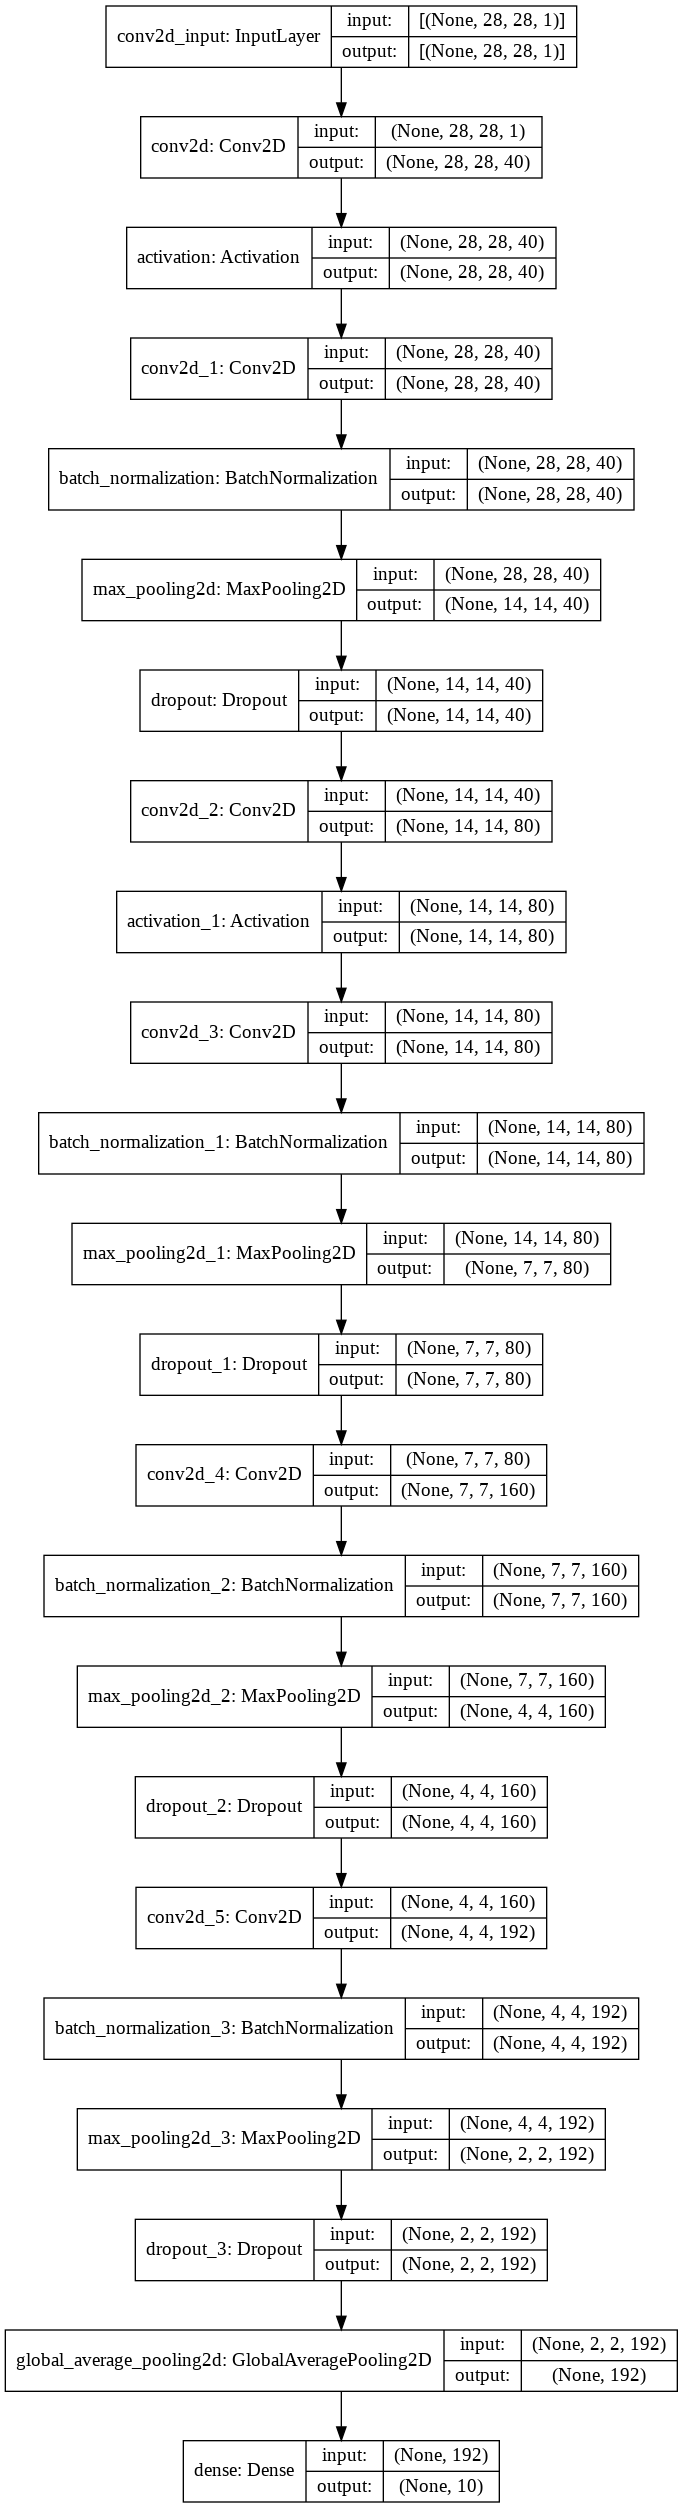

In [7]:
# SAVING AND VISUALIZATION OF A MODEL  
#-----------------------------------------------------------
nume_dorit='nlcnn_mnist_99_72'  # desired name for your model 
model.save(nume_dorit+'.h5')  

from keras.utils.vis_utils import plot_model
plot_model(model, to_file=nume_dorit+'.png', show_shapes=True, show_layer_names=True, dpi=96)

In [8]:
# RUN THIS CELL ONLY TO PREPARE DATA FOR MOBILENETv2 
# expands to 32x32 and 3 channels 

from skimage import transform
# from https://github.com/astorfi/TensorFlow-World/tree/master/docs/tutorials/3-neural_network/autoencoder

def resize_batch(imgs):
    # A function to resize a batch of MNIST images to (32, 32)
    # Args:
    #   imgs: a numpy array of size [batch_size, 28 X 28].
    # Returns:
    #   a numpy array of size [batch_size, 32, 32].
    imgs = imgs.reshape((-1, 28, 28, 1))
    resized_imgs = np.zeros((imgs.shape[0], 32, 32, 1))
    for i in range(imgs.shape[0]):
        resized_imgs[i, ..., 0] = transform.resize(imgs[i, ..., 0], (32, 32))
    return resized_imgs


x_train=resize_batch(x_train)
x_test=resize_batch(x_test)

# 3 chans expansion  
if inp_chan<3:
  
  x_train = np.repeat(x_train, 3, -1)
  x_test =  np.repeat(x_test, 3, -1)
input_shape=np.shape(x_train)[1:4]



In [9]:
# PRETRAINED MODELS (e.g. MOBILENET )
# Data must have at least 32x32 image size and 3 channles 
#  
#----------------------------------------------------------------

import tensorflow as tf
import keras
import numpy as np # linear algebra
import keras.backend as K 

import time as ti 
import scipy.io as sio

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, DepthwiseConv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, SeparableConv2D  # straturi convolutionale si max-pooling 
from keras.optimizers import RMSprop, SGD, Adadelta, Adam, Nadam

import matplotlib.pyplot as plt

def create_model():
  
  #pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[input_shape[0], input_shape[1], 3], include_top=False)
  pretrained_model = tf.keras.applications.MobileNetV2(alpha=0.75, input_shape=[input_shape[0], input_shape[1], 3], include_top=False)
  pretrained_model.trainable = True   
  # True - all weights are trained; False: only the output layer is trained 

  model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    #tf.keras.layers.Dense(1000,activation='relu'),  # Numai daca se doreste un strat dens suplimentar 
    tf.keras.layers.Dense(num_classes, activation='softmax')
  ])
  myopt = Adam()
  #myopt = Nadam()
  # --------------------------   LOSS function  ------------------------------------
  my_loss='categorical_crossentropy'
  model.compile(loss=my_loss, 
              optimizer=myopt,   
              metrics=['accuracy'])
  return model

model = create_model()
model.summary()

# Now you can go back to the training cell !



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_0.75_224 (Functi (None, 1, 1, 1280)        1382064   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                12810     
Total params: 1,394,874
Trainable params: 1,368,234
Non-trainable params: 26,640
_________________________________________________________________


/ 0 epoch lasted  13.456864595413208  seconds
Improved in epoch: 0  New accuracy:  32.96000063419342 %
/ 1 epoch lasted  9.269582748413086  seconds
Improved in epoch: 1  New accuracy:  67.25999712944031 %
/ 2 epoch lasted  9.22437047958374  seconds
Improved in epoch: 2  New accuracy:  73.68000149726868 %
/ 3 epoch lasted  9.239910125732422  seconds
Improved in epoch: 3  New accuracy:  94.84000205993652 %
/ 4 epoch lasted  9.234206438064575  seconds
/ 5 epoch lasted  9.238868474960327  seconds
Improved in epoch: 5  New accuracy:  98.24000000953674 %
/ 6 epoch lasted  9.250972270965576  seconds
/ 7 epoch lasted  9.2447509765625  seconds
/ 8 epoch lasted  9.23220157623291  seconds
Improved in epoch: 8  New accuracy:  98.64000082015991 %
/ 9 epoch lasted  9.263878345489502  seconds
Best accuracy: 98.64000082015991 % reached in epoch:  8  running   10  epochs lasts  114.33414626121521  seconds
Total number of parameters:  1394874
Test accuracy: 0.9864000082015991
Time to predict on the test

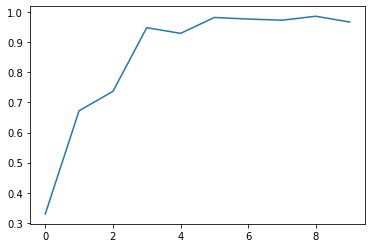

In [10]:
# TRAINING OF THE MOBILENET MODEL  
#-----------------  for reproductibility  ----------------------
import tensorflow as tf 
from numpy.random import seed
seed(1)
tf.random.set_seed(2)
#----------------------------------------------------

import keras
import numpy as np # linear algebra
import keras.backend as K 

import time as ti 
import scipy.io as sio
import matplotlib.pyplot as plt

#=====================================================================
batch_size = 100  # Ranging betwee 10 (small datasets) to 100 (larger datasets)
epoci = 10 # maximal number of training epochs (the best result may be obtained earlier)
#----------------------------------------------------------------------------------------

err_test=np.zeros(epoci)   # For plotting test error evolution  
best_acc=0.0
best_ep=0
t1=ti.time()
for k in range(epoci):
      tx=ti.time()
      model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=1,
              verbose=0,  # aici 0 (nu afiseaza nimic) 1 (detaliat) 2(numai epocile)
              validation_data=(x_test, y_test))
      
      ty=ti.time()
      print('/',k,'epoch lasted ',ty-tx,' seconds')
      
      score = model.evaluate(x_test, y_test, verbose=0)
      
      err_test[k]=score[1]
      if score[1]>best_acc : 
            print('Improved in epoch:', k, ' New accuracy: ', 100*score[1],'%')
            best_acc=score[1]
            best_ep=k
            bp=model.get_weights()
t2=ti.time()
print('Best accuracy:', best_acc*100, '% reached in epoch: ',best_ep, ' running  ',epoci,' epochs lasts ',t2-t1,' seconds')
plt.plot(err_test)
model.set_weights((bp)) # evaluete prediction time on all test samples
t1=ti.time()

score = model.evaluate(x_test, y_test, verbose=0)

t2=ti.time()
print ('Total number of parameters: ',model.count_params())
print('Test accuracy:', score[1])
print ('Time to predict on the test set : ',t2-t1)
print('Latency (per input sample):', 1000*(t2-t1)/np.shape(x_test)[0], 'ms')


Original label: 2.0
Recognized label:  2


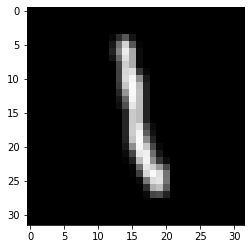

In [11]:
# SOME EXAMPLES  

selectia=int(np.shape(x_test)[0]*np.random.rand(1))  # 

img1=x_test[selectia,:,:,:]
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
if np.shape(x_train)[3]==1:
  plt.imshow(img1[:,:,0],cmap='gray')
elif np.shape(x_train)[3]==3:
  plt.imshow(img1)

label=np.dot(y_test[selectia,:],1+np.array(range(num_classes)).T)
print('Original label:', label)
z=model.predict(x_test[selectia:selectia+1,:,:,:])
print('Recognized label: ',1+np.argmax(z))



In [15]:
from keras.models import load_model
model=load_model('nlcnn_mnist_99_72.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 40)        400       
_________________________________________________________________
activation (Activation)      (None, 28, 28, 40)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 40)        14440     
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 40)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 40)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 40)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 80)        2

In [16]:
# EVALUATE MODEL (BE CAREFUL TO LOAD THE SPECIFIC DATASET )
t1=ti.time()
score = model.evaluate(x_test, y_test, verbose=0)
t2=ti.time()
print('Test accuracy:', score[1])
print ('Time for test set : ',t2-t1)
#cfg=model.get_config()
#cfg

Test accuracy: 0.9972000122070312
Time for test set :  0.8381707668304443
